Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Read the dataset from the S3 bucket

In [2]:
# main bucket
bucket='maxis-problem'

# cleaned dataset saved from data wrangler
# removed outliers, feature selection, ONE_HOT encoding, SMOTE
s3uri = 's3://sagemaker-ap-southeast-1-117213039920/finaldata16722/output_1657956822/part-00000-a0ef82c6-52e1-4393-b500-6626b5b0a2e6-c000.csv'

df_newest = pd.read_csv(s3uri)
df_newest

,LRD,Backup Hour,Aging Days,Power Event Count,DC_Admin_Status,Total_Bank,DC_Technology,DC_Brand_Narada,DC_Brand_Enersys,DC_Brand_Huawei,...,Cooling_System_HEX,Cooling_System_Air Conditioner,Cooling_System_FCU,Cooling_System_FCU Hybrid,CS_Site_Type_Vacant Land,CS_Site_Type_Rooftop,CS_Site_Type_Inbuilding,DC_Capacity_150.0,DC_Capacity_100.0,DC_Capacity_155.0
0,LRD3762,1.000000,927.00000,1.000000,0.0,2.00000,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0
1,LRD6090,3.000000,1156.00000,1.000000,0.0,2.00000,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0
2,LRD4307,3.000000,1545.00000,1.000000,0.0,2.00000,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.0
3,LRD17277,5.000000,1088.00000,1.000000,0.0,1.00000,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,1.000000,0.0
4,LRD3246,5.000000,1691.00000,1.000000,0.0,2.00000,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,LRD8378,3.000000,962.00000,0.617654,0.0,1.00000,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.426481,0.573519,0.0,0.000000,1.000000,0.0
2696,LRD20611,1.000000,968.02734,1.000000,0.0,2.00000,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.000000,0.000000,0.0,0.000000,1.000000,0.0
2697,LRD11937,1.403180,932.00000,0.701590,0.0,1.40318,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0
2698,LRD10949,0.135887,1191.42870,0.098010,0.0,1.00000,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.067943,0.932057,0.0,0.932057,0.067943,0.0


In [3]:
# copy the data
df_scale = df_newest.copy()
  
# apply normalization techniques
# df_min_max_scaled["Aging Days"] = (df_min_max_scaled["Aging Days"] - df_min_max_scaled["Aging Days"].min()) / (df_min_max_scaled["Aging Days"].max() - df_min_max_scaled["Aging Days"].min())   
# df_min_max_scaled

**Splitting the training and testing data**

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale 

#Define X(input features) and Y(output)
X = df_scale.drop(['LRD', 'Aging Days'], axis = 1)
y = df_scale['Aging Days']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# defined K fold for croos validaton
cv = KFold(n_splits = 12, shuffle = True)

**Ridge Regression Model**

In [5]:
# Ridge Regression
from sklearn.linear_model import Ridge

#Ridge regression using pipeliner
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipeline.fit(X_train, y_train)
#save prediction
pred1 = pipeline.predict(X_test)
# print('Ridge Regression Accuracy (r2 score): %.3f' % (np.max(scores)))


**Partial Least Squares (PLS) Regression**

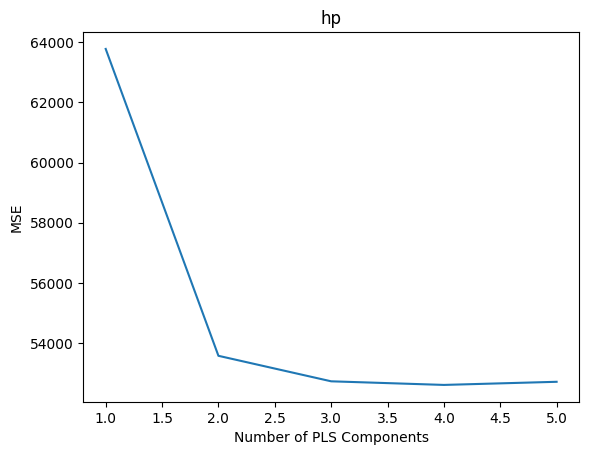

In [6]:
# PLS Regression: Determining Optimal number of components
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt

mse = []
n = len(X)

# Calculate MSE with only the intercept
score = -1 * cross_val_score(PLSRegression(n_components = 1),
        np.ones((n,1)), y, cv = cv, scoring = 'neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
  pls = PLSRegression(n_components=i)
  score = -1 * cross_val_score(pls, scale(X), y, cv = cv,
          scoring='neg_mean_squared_error').mean()
  mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')
plt.show()

In [7]:
#PLS Regression
pls = PLSRegression(n_components=2)
pls.fit(X_train,y_train)
pred2 = pls.predict(X_test)
# print('PLS Regression Accuracy (r2 score): %.3f' % (max(scores)))

**Standard vector regression**

In [8]:
#Support Vector Regression (SVR)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

sc_X = StandardScaler()
sc_y = StandardScaler()
#Tranform data before feeding model to suit the input
SVR_X = sc_X.fit_transform(X_train)
SVR_y = sc_y.fit_transform(y_train.values.reshape(-1,1))

regressor = SVR(kernel = 'rbf')
regressor.fit(SVR_X, SVR_y.ravel())
#Predicted values should be transformed back to original form
pred3 = sc_y.inverse_transform(regressor.predict(sc_X.fit_transform(X_test)).reshape(-1,1))
# print('Support Vector Regression Accuracy (r2 score): %.3f' % (max(scores)))

**Elastic Net Regression**

In [9]:
#Elastic Net Regression
from sklearn.linear_model import ElasticNet, ElasticNetCV

enet_cv_model_alpha = ElasticNetCV(cv = 20).fit(X_train, y_train)
enet_model = ElasticNet(alpha = enet_cv_model_alpha.alpha_).fit(X_train, y_train)
pred4 = enet_model.predict(X_test)
# print('Net Elastic Regression Accuracy (r2 score): %.3f' % (max(scores)))

In [10]:
#Ensemble learning (bagging) hard code
#Find average of predictions of 4 models
#Final accuracy based on mean_predicton 

#Create df to store show predictions from 4 models
prediction_list = pd.DataFrame(np.column_stack([np.round(pred1), np.round(pred2), np.round(pred3), np.round(pred4)]), 
                               columns=['Ridge', 'PLS', 'SVR', 'Enet'])
#Calcualte mean of 4 predictions
prediction_list['mean'] = round(prediction_list.sum(axis=1) / 4)
# y_test = y_test * (df_newest["Aging Days"].max() - df_newest["Aging Days"].min()) + df_newest["Aging Days"].min()
#Add column for Actual Prediction for comparison
prediction_list['Actual Days'] = np.round(y_test.values.tolist())
final_pred = prediction_list['mean']

In [11]:
prediction_list

,Ridge,PLS,SVR,Enet,mean,Actual Days
0,1408.0,1367.0,1516.0,1387.0,1420.0,1209.0
1,1235.0,1203.0,1224.0,1199.0,1215.0,1440.0
2,984.0,1014.0,964.0,988.0,988.0,962.0
3,1417.0,1412.0,1699.0,1342.0,1468.0,1481.0
4,1396.0,1406.0,1178.0,1410.0,1348.0,880.0
...,...,...,...,...,...,...
535,1456.0,1467.0,1692.0,1454.0,1517.0,1798.0
536,1310.0,1323.0,1312.0,1302.0,1312.0,1475.0
537,1353.0,1358.0,1615.0,1331.0,1414.0,1250.0
538,1292.0,1236.0,1139.0,1287.0,1238.0,1364.0


In [40]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
#Error metrics: MAE, R2, RMSE
r2 = r2_score(y_test, final_prediction)
final_prediction = prediction_list['mean'] 
print("final accuracy based on ensemble learning: ")
print("mae: ", mean_absolute_error(y_test, final_prediction))
print("r2: ", r2)
print("rmse: ", math.sqrt(mean_squared_error(y_test, final_prediction)))

final accuracy based on ensemble learning: 
mae:  159.27084048148149
r2:  0.6518046627152719
rmse:  219.640341652252


In [13]:
#Determine best model using K-fold
#Max to show best scenario prediction
accumulated_scores = {
'Ridge': np.max(cross_val_score(pipeline, X_test, y_test, scoring = 'r2', cv=cv, n_jobs=-1)),
'PLS' : np.max(cross_val_score(pls, X_test, y_test, scoring = 'r2', cv = cv, n_jobs = -1)),
'SVR' : np.max(cross_val_score(regressor, sc_X.fit_transform(X_test), sc_y.fit_transform(y_test.values.reshape(-1,1)), scoring = 'r2', cv = cv, n_jobs = -1)),
'ENET' : np.max(cross_val_score(enet_model, X_test, y_test, scoring = 'r2', cv = cv, n_jobs = -1))
}
print(accumulated_scores)
best = max(accumulated_scores, key=accumulated_scores.get)
mean = mean(accumulated_scores, key=accumulated_scores.get)

{'Ridge': 0.7282896322263149, 'PLS': 0.7452211888375426, 'SVR': 0.8354360761444259, 'ENET': 0.640989636185199}


In [48]:
#Accuracy metric dataframe

Accuracy_plot = pd.DataFrame()
Accuracy_plot = Accuracy_plot.append(accumulated_scores , ignore_index=True)
Accuracy_plot['Ensemble Learning'] = r2
Accuracy_plot = Accuracy_plot.rename(index={0: 'Accuracy'})
Accuracy_plot

,Ridge,PLS,SVR,ENET,Ensemble Learning
Accuracy,0.72829,0.745221,0.835436,0.64099,0.651805


Predicting Null Entries for Problem 2 

In [32]:
#import clean dataset from data wrangler
#same format as above but entries with null aging days

s3uri1 = 's3://sagemaker-ap-southeast-1-117213039920/problem2dataset/output_1657898960/part-00000-a4f700a0-cfbb-4d22-9741-e7f2459c2181-c000.csv'

df_pred = pd.read_csv(s3uri1)
df_pred

,LRD,Backup Hour,Power Event Count,DC_Admin_Status,Total_Bank,DC_Technology,DC_Brand_Narada,DC_Brand_Enersys,DC_Brand_MSB,DC_Brand_Huawei,Cooling_System_HEX,Cooling_System_Air Conditioner,Cooling_System_FCU,Cooling_System_FCU Hybrid,CS_Site_Type_Vacant Land,CS_Site_Type_Rooftop,CS_Site_Type_Inbuilding,DC_Capacity_150.0,DC_Capacity_100.0,DC_Capacity_155.0
0,LRD12718,6,1.000000,1,2.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,LRD1791,6,1.000000,0,1.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,LRD2211,4,1.000000,0,3.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,LRD2211,4,1.000000,0,3.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,LRD4858,4,0.500000,0,2.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840,LRD2649,6,0.250000,0,2.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2841,LRD2649,0,0.250000,0,2.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2842,LRD2649,0,0.250000,0,2.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2843,LRD18075,1,1.000000,0,1.0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [33]:
#input features to predict
X_pred = df_pred.drop(['LRD'], axis = 1)

#To store prediction
y_pred = []
if best == 'Ridge':
  y_pred = pipeline.predict(X_pred)

elif best == 'PLS':
  y_pred = pls.predict(X_pred)

elif best == 'SVR':
  y_pred = sc_y.inverse_transform(regressor.predict(sc_X.fit_transform(X_pred)).reshape(-1,1))

else:
  y_pred = enet_model.predict(X_pred)

print("Best model:", best)
print("Best possible accuracy (R2) of model using k-fold:", accumulated_scores[best])

Best model: SVR
Best possible accuracy (R2) of model using k-fold: 0.8354360761444259


In [16]:
#Add predicted aging days to df_pred 
df_pred["Aging Days"] = y_pred
df_pred
#rename columns to be concatenated with df_newest
#df_newest includes entries with provided Aging Days
#combine both df to be used in problem 2 classification 
#merge df includes predicted and given Aging Days

df_pred.columns = ['LRD', 'Backup Hour', 'Power Event Count', 'DC_Admin_Status',
       'Total_Bank', 'DC_Technology', 'DC_Brand_Narada',  'DC_Brand_Enersys',
       'DC_Brand_MSB','DC_Brand_Huawei', 'Cooling_System_HEX', 
       'Cooling_System_Air Conditioner', 'Cooling_System_FCU',
       'Cooling_System_FCU Hybrid','CS_Site_Type_Vacant Land', 
        'CS_Site_Type_Rooftop', 'CS_Site_Type_Inbuilding', 
        'DC_Capacity_150.0', 'DC_Capacity_100.0', 
        'DC_Capacity_155.0', 'Aging Days']

In [17]:
All_Predictions = pd.concat([df_newest, df_pred], ignore_index = True)

#save to bucket, use as input for problem 2

,LRD,Backup Hour,Aging Days,Power Event Count,DC_Admin_Status,Total_Bank,DC_Technology,DC_Brand_Narada,DC_Brand_Enersys,DC_Brand_Huawei,...,Cooling_System_HEX,Cooling_System_Air Conditioner,Cooling_System_FCU,Cooling_System_FCU Hybrid,CS_Site_Type_Vacant Land,CS_Site_Type_Rooftop,CS_Site_Type_Inbuilding,DC_Capacity_150.0,DC_Capacity_100.0,DC_Capacity_155.0
0,LRD3762,1.0,927.000000,1.000000,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,LRD6090,3.0,1156.000000,1.000000,0.0,2.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,LRD4307,3.0,1545.000000,1.000000,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,LRD17277,5.0,1088.000000,1.000000,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,LRD3246,5.0,1691.000000,1.000000,0.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5540,LRD2649,6.0,1566.919487,0.250000,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5541,LRD2649,0.0,1164.757604,0.250000,0.0,2.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5542,LRD2649,0.0,1630.937597,0.250000,0.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5543,LRD18075,1.0,1221.733530,1.000000,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [18]:
#Save final output to bucket to be used in problem 2
import boto3 
import os

prefix = 'Results'
All_Predictions.to_csv('Problem1Result.csv', index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'problem-1/Results.csv')).upload_file('Problem1Result.csv')

**Save models to buckets**

In [19]:
pip install mxnet

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Define IAM role
import boto3
import re

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket = "maxis-problem"

In [21]:
import gzip
import pickle
import os

**Export Elastic Net to S3 Bucket**

In [22]:
import mxnet as mx

elastic_centroids = mx.ndarray.array(enet_cv_model_alpha.alphas)
mx.ndarray.save("elastic_model", [elastic_centroids])

In [23]:
!tar czvf elastic-model.tar.gz elastic_model

elastic_model


In [24]:
prefix = "elastic-net-model"

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "elastic-model.tar.gz")
).upload_file("elastic-model.tar.gz")

**Export SVR to S3 Bucket**

In [25]:
svr_centroids = mx.ndarray.array(regressor.class_weight_)
mx.ndarray.save("svr_model", [svr_centroids])

In [26]:
!tar czvf svr-model.tar.gz svr_model

svr_model


In [27]:
prefix = 'svr-model'

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "svr-model.tar.gz")
).upload_file("svr-model.tar.gz")

**Export PLS to S3 Bucket**

In [28]:
pls_centroids = mx.ndarray.array(pls.coef_)
mx.ndarray.save("pls_model", [pls_centroids])

In [29]:
!tar czvf pls-model.tar.gz pls_model

pls_model


In [30]:
prefix = 'pls-model'

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "pls-model.tar.gz")
).upload_file("pls-model.tar.gz")